On s'intéresse à l'EDO sur $[0,3]$
$$
\frac{d^2u}{dt^2} +\pi^2 \sin(\pi t) = 0,\quad u(0)=0=u(3).
$$
On connaît la solution. Les 'datas' sont les résidus de l'équation différentielle et les conditions au bord.

C'est un exemple basique avec des outils basiques.

On se sert d'abord uniquement de **JAX**

     0    4.269e+01
   300    2.147e+01
   600    1.905e+01
   900    1.213e+01
  1200    5.309e+00
  1500    4.723e+00
  1800    4.545e+00
  2100    4.299e+00
  2400    2.145e+00
  2700    5.100e-01
  3000    1.036e-01
  3300    1.910e-02
  3600    3.917e-03
  3900    9.824e-04
  4200    2.887e-04
  4500    9.109e-05
  4800    2.942e-05
  5100    9.542e-06
  5400    3.109e-06
  5700    1.009e-06


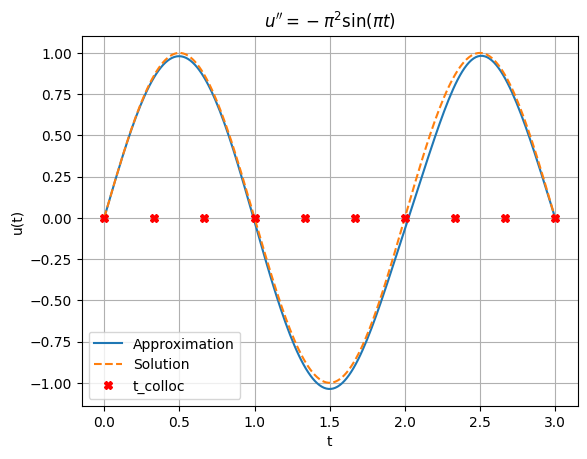

In [39]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np

# Commençons par la fonction de visu
def plot_solutions(t_plot, t_colloc, u1, u2, t1='Approximation', t2='Solution', ls1='', ls2='--'):
    plt.plot(t_plot, u1, ls1, label=t1)
    plt.plot(t_plot, u2, ls2, label=t2)
    plt.plot(t_colloc, np.zeros_like(t_colloc), 'Xr', label='t_colloc')
    plt.legend()
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.title(r"$u'' = -\pi^2 \sin(\pi t)$")
    plt.grid(True)
    plt.show()

# Points de collocation
t0, t1, n_colloc = 0, 3, 10
t_colloc = jnp.linspace(t0, t1, n_colloc)
# Machine
layers = [1, 8, 8, 1]
# Initialisation des paramètres
def init_params():
    key = jax.random.PRNGKey(0)
    key, subkey = jax.random.split(key)
    params = []
    for l in range(1,len(layers)):
        in_dim, out_dim =  layers[l-1], layers[l]
        key, subkey = jax.random.split(key)
        W = jax.random.normal(subkey, (out_dim, in_dim)) * jnp.sqrt(2 / in_dim)
        b = jnp.zeros(out_dim)
        params.append((W,b))
    return params
def forward(params, t):
    t = jnp.array([t])
    for W, b in params[:-1]:
        t = jnp.tanh(W @ t + b)
    W, b = params[-1]
    return (W @ t +b)[0]
# Calcul de u''(x) par JAX autodiff
def dudt(params, t):
    return jax.grad(forward, argnums=1)(params, t)
def d2udt2(params, t):
    return jax.grad(dudt, argnums=1)(params, t)
def residual(params, t):
    return d2udt2(params, t) + (jnp.pi ** 2) * jnp.sin(jnp.pi * t)
# Total loss = ode + boundary conditions
def loss(params):
    # Physics loss
    res = jax.vmap(lambda t: residual(params, t))(t_colloc)
    ode_loss = jnp.mean(res ** 2)
    # Boundary conditions
    bc_loss = forward(params, t_colloc[0]) ** 2 + forward(params, t_colloc[-1]) ** 2
    return ode_loss + bc_loss

params = init_params()
# Une itération de gradient
@jax.jit
def update(params, lr):
    grads = jax.grad(loss)(params)
    return  [(w - lr * dw, b - lr * db) for (w, b), (dw, db) in zip(params, grads)]
# Boucle d'entraînement
lr, n_epochs = 0.001, 6000
for epoch in range(n_epochs):
    params = update(params, lr=lr)
    if epoch % 300 == 0:
        loss_val = loss(params)
        print(f"{epoch:6d} {loss_val:12.3e}")


# Visu
t_plot = jnp.linspace(t0, t1, 200)
u_pred = jax.vmap(lambda t: forward(params,t))(t_plot)
u_true = jnp.sin(jnp.pi * t_plot)

plot_solutions(t_plot, t_colloc, u_pred, u_true)

On peut utiliser des outils plus performants comme les librairies :
* **FLAX** définit des réseaux de neuronnes
* **OPTAX** donne accès à un grand nombre d'algorithmes d'optimisation

D'abord, on reprend le même exemple avec OPTAX

Epoch       0, Loss: 4.343e+01
Epoch     100, Loss: 6.612e-02
Epoch     200, Loss: 7.698e-07
Epoch     300, Loss: 2.712e-08


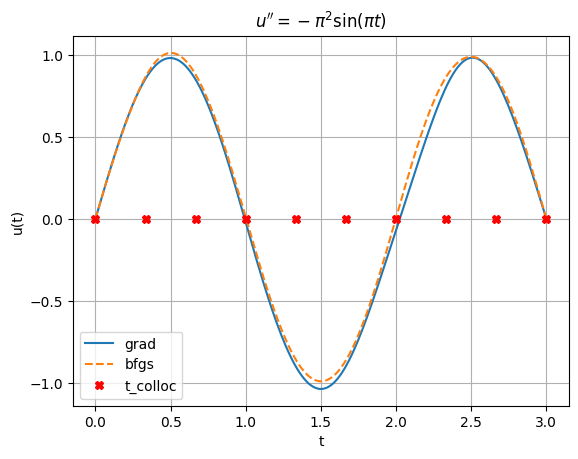

In [40]:
        import optax

        params = init_params()
        optimizer = optax.lbfgs(learning_rate=lr)
        opt_state = optimizer.init(params)
        @jax.jit
        def train_step(params, opt_state):
            loss_value, grads = jax.value_and_grad(loss)(params)
            updates, opt_state = optimizer.update(
                grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
            )
            params = optax.apply_updates(params, updates)
            return params, opt_state, loss_value, grads, updates

        n_epochs = 400
        for epoch in range(n_epochs):
            params, opt_state, loss_value, grads, updates = train_step(params, opt_state)
            if epoch % 100== 0:
                print(f"Epoch {epoch:7d}, Loss: {loss_value:.3e}")

        # Visu
        t_plot = jnp.linspace(t0, t1, 200)
        u_pred2 = jax.vmap(lambda t: forward(params,t))(t_plot)
        u_true = jnp.sin(jnp.pi * t_plot)

        plot_solutions(t_plot, t_colloc, u_pred, u_pred2, t1='grad', t2='bfgs')


Finalement, on utilise aussi FLAX, ou plutôt sa partie nnx.
Cela ressemble à pytorch dans l'idée, mais le traîtement de paramètres est différent.

Epoch       0, Loss: 4.140e+01
Epoch     100, Loss: 2.844e+00
Epoch     200, Loss: 1.907e-05
Epoch     300, Loss: 7.766e-08


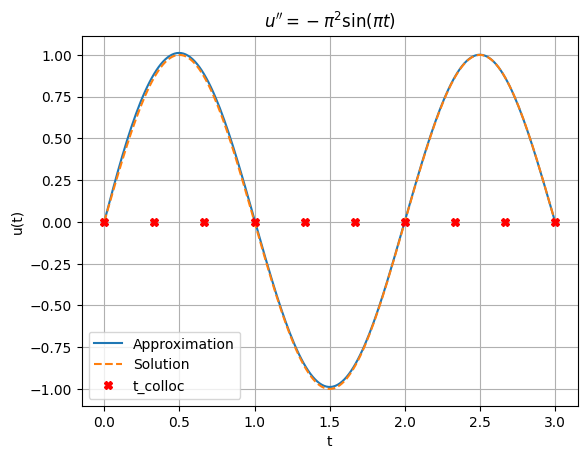

In [43]:
from flax import nnx
class MLP(nnx.Module):
    def __init__(self, layers):
        key = jax.random.PRNGKey(0)
        key, subkey = jax.random.split(key)
        self.layers = []
        for l in range(1,len(layers)):
            in_dim, out_dim =  layers[l-1], layers[l]
            key, subkey = jax.random.split(key)
            layer = nnx.Linear(in_dim, out_dim, rngs=nnx.Rngs(key))
            self.layers.append(layer)
            in_dim = out_dim
    def forward(self, t):
        t = jnp.array([t])
        for layer in self.layers[:-1]:
            t = jnp.tanh(layer(t))
        last_layer = self.layers[-1]
        return last_layer(t)[0]
# Calcul de u''(x) par JAX autodiff
    def dudt(self, t):
        return jax.grad(self.forward)(t)
    def d2udt2(self, t):
        return jax.grad(self.dudt)(t)
    def residual_ode(self, t):
        return self.d2udt2(t) + (jnp.pi ** 2) * jnp.sin(jnp.pi * t)
    def residual_bc(self, t0, t1):
        return self.forward(t0) **2 + self.forward(t1)**2

machine = MLP(layers)
# on récupère tous les ingrédients du 'module'
graphdef, params, batch_stats = nnx.split(machine, nnx.Param, nnx.BatchStat)
def loss(params):
    # on reconstruit une machine avec les paramètres actuels
    machine_tmp = nnx.merge(graphdef, params, batch_stats)
    res = jax.vmap(machine_tmp.residual_ode)(t_colloc)
    ode_loss = jnp.mean(res ** 2)
    # Boundary conditions
    bc_loss = machine_tmp.residual_bc(t_colloc[0], t_colloc[-1])
    return ode_loss + bc_loss

optimizer = optax.lbfgs(learning_rate=0.001)
opt_state = optimizer.init(params)
@jax.jit
def train_step(params, opt_state):
    loss_value, grads = jax.value_and_grad(loss)(params)
    updates, opt_state = optimizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value, grads, updates
n_epochs = 400
for epoch in range(n_epochs):
    params, opt_state, loss_value, grads, updates = train_step(params, opt_state)
    if epoch % 100== 0:
        print(f"Epoch {epoch:7d}, Loss: {loss_value:.3e}")

# on reconstruit une machine avec les paramètres trouvés
trained_machine = nnx.merge(graphdef, params, batch_stats)
# Visu
t_plot = jnp.linspace(t0, t1, 200)
u_pred = jax.vmap(trained_machine.forward)(t_plot)
u_true = jnp.sin(jnp.pi * t_plot)

plot_solutions(t_plot, t_colloc, u_pred, u_true)
